# Federated AdamProx PyTorch MNIST Tutorial
The only difference between this notebook and Federated_Pytorch_MNIST_Tutorial.ipynb is overriding of the `train_epoch` function in model definition. [See details](#FedProx)


In [1]:
#Install dependencies if not already installed
!pip install torch torchvision

You should consider upgrading via the '/home/radionov/.envs/fedprox/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet
import random
import warnings
warnings.filterwarnings('ignore')
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(10)


After importing the required packages, the next step is setting up our openfl workspace. To do this, simply run the `fx.init()` command as follows:

In [3]:
#Setup default workspace, logging, etc.
fx.init('torch_cnn_mnist')

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── __init__.py
├── mu0.log
├── impl
│   ├── __init__.py
│   ├── pt_cnn_fetschallenge.py
│   ├── challenge_assigner.py
│   ├── ptmnist_inmemory.py
│   ├── __pycache__
│   │   ├── fets_challenge_model.cpython-37.pyc
│   │   ├── challenge_assigner.cpython-37.pyc
│   │   ├── ptmnist_inmemory.cpython-36.pyc
│   │   ├── __init__.cpython-36.pyc
│   │   ├── mnist_utils.cpython-36.pyc
│   │   ├── fets_challenge_model.cpython-36.pyc
│   │   ├── challenge_assigner.cpython-36.pyc
│   │   ├── pt_cnn_fetschallenge.cpython-36.pyc
│   │   ├── __init__.cpython-37.pyc
│   │   ├── fets_challenge_dataloader.cpython-36.pyc
│   │   └── fets_challenge_dataloader.cpython-37.pyc
│   ├── mnist_utils.py
│   ├── fets_challenge_model.py
│   └── fets_challenge_dataloader.py
├── .workspace
├── _bootstrap.py
├── data
│   ├── MICCAI_BraTS2020_TrainingData
│   │   ├── BraTS20_Training_210
│   │   ├── BraTS20_Train

│   │   ├── BraTS20_Training_343
│   │   ├── BraTS20_Training_086
│   │   ├── BraTS20_Training_169
│   │   ├── BraTS20_Training_294
│   │   ├── BraTS20_Training_109
│   │   ├── BraTS20_Training_011
│   │   ├── BraTS20_Training_235
│   │   ├── BraTS20_Training_254
│   │   ├── BraTS20_Training_106
│   │   ├── BraTS20_Training_064
│   │   ├── BraTS20_Training_180
│   │   ├── BraTS20_Training_261
│   │   ├── BraTS20_Training_207
│   │   ├── BraTS20_Training_055
│   │   ├── BraTS20_Training_368
│   │   ├── BraTS20_Training_047
│   │   ├── BraTS20_Training_070
│   │   ├── BraTS20_Training_369
│   │   ├── BraTS20_Training_133
│   │   ├── BraTS20_Training_062
│   │   ├── BraTS20_Training_201
│   │   ├── BraTS20_Training_228
│   │   ├── BraTS20_Training_295
│   │   ├── BraTS20_Training_214
│   │   ├── BraTS20_Training_122
│   │   ├── BraTS20_Training_030
│   │   ├── BraTS20_Training_320
│   │   ├── BraTS20_Training_222
│   │   ├── BraTS20_Training_304
│   │   ├── BraTS20_Training_103
│   │   ├─

│   │   ├── n02883205
│   │   ├── n02206856
│   │   ├── n02823428
│   │   ├── n04371430
│   │   ├── n01950731
│   │   ├── n02085620
│   │   ├── n01742172
│   │   ├── n03970156
│   │   ├── n03670208
│   │   ├── n07579787
│   │   ├── n02236044
│   │   ├── n01770393
│   │   ├── n04099969
│   │   ├── n02321529
│   │   ├── n03763968
│   │   ├── n03444034
│   │   ├── n02791270
│   │   ├── n04275548
│   │   ├── n01917289
│   │   ├── n01910747
│   │   ├── n07768694
│   │   ├── n03255030
│   │   ├── n04532670
│   │   ├── n04259630
│   │   ├── n02279972
│   │   ├── n02480495
│   │   ├── n03250847
│   │   ├── n03770439
│   │   ├── n04118538
│   │   ├── n03891332
│   │   ├── n04356056
│   │   ├── n04465501
│   │   ├── n04070727
│   │   ├── n12267677
│   │   ├── n03160309
│   │   ├── n02481823
│   │   ├── n04560804
│   │   ├── n04501370
│   │   ├── n02666196
│   │   ├── n03404251
│   │   ├── n01641577
│   │   ├── n03649909
│   │   ├── n03584254
│   │   ├── n02056570
│   │   ├── n02808440
│   │   ├─

Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [4]:
def one_hot(labels, classes):
    return np.eye(classes)[labels]

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

VALID_PERCENT = 0.3

(X_train, y_train), (X_test, y_test) = mnist.load_data()
split_on = int((1 - VALID_PERCENT) * len(X_train))

train_images = X_train[0:split_on,:,:]
train_labels = to_categorical(y_train)[0:split_on,:]

valid_images = X_train[split_on:,:,:]
valid_labels = to_categorical(y_train)[split_on:,:]

test_images = X_test
test_labels = to_categorical(y_test)

def preprocess(images):
    #Normalize
    images = (images / 255) - 0.5
    images = images.reshape(images.shape[0], -1)
    return images

# Preprocess the images.
train_images = preprocess(train_images)
valid_images = preprocess(valid_images)
test_images = preprocess(test_images)

feature_shape = train_images.shape[1:]
classes = 10
collaborator_num = 300

In [7]:
valid_labels = valid_labels.astype(int)
train_labels = train_labels.astype(int)
train_images = train_images.astype('float32')
valid_images = valid_images.astype('float32')

# AdamProx

In [9]:
from openfl.utilities.optimizers.torch import AdamProx

In [10]:
feature_shape = train_images.shape[1]
classes       = 10
NUM_USER = collaborator_num

def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex


def generate_synthetic(alpha, beta, iid):

    dimension = 60
    NUM_CLASS = 10
    
    samples_per_user = np.random.lognormal(4, 2, (NUM_USER)).astype(int) + 50
    num_samples = np.sum(samples_per_user)

    X_split = [[] for _ in range(NUM_USER)]
    y_split = [[] for _ in range(NUM_USER)]


    #### define some eprior ####
    mean_W = np.random.normal(0, alpha, NUM_USER)
    mean_b = mean_W
    B = np.random.normal(0, beta, NUM_USER)
    mean_x = np.zeros((NUM_USER, dimension))

    diagonal = np.zeros(dimension)
    for j in range(dimension):
        diagonal[j] = np.power((j+1), -1.2)
    cov_x = np.diag(diagonal)

    for i in range(NUM_USER):
        if iid == 1:
            mean_x[i] = np.ones(dimension) * B[i]  # all zeros
        else:
            mean_x[i] = np.random.normal(B[i], 1, dimension)

    if iid == 1:
        W_global = np.random.normal(0, 1, (dimension, NUM_CLASS))
        b_global = np.random.normal(0, 1,  NUM_CLASS)

    for i in range(NUM_USER):

        W = np.random.normal(mean_W[i], 1, (dimension, NUM_CLASS))
        b = np.random.normal(mean_b[i], 1,  NUM_CLASS)

        if iid == 1:
            W = W_global
            b = b_global

        xx = np.random.multivariate_normal(mean_x[i], cov_x, samples_per_user[i])
        yy = np.zeros(samples_per_user[i])

        for j in range(samples_per_user[i]):
            tmp = np.dot(xx[j], W) + b
            yy[j] = np.argmax(softmax(tmp))

        X_split[i] = xx.tolist()
        y_split[i] = yy.tolist()

#         print("{}-th users has {} exampls".format(i, len(y_split[i])))


    return X_split, y_split

class SyntheticFederatedDataset(FederatedDataSet):
    def split(self, num_collaborators, shuffle=True, equally=False):
        X, y = generate_synthetic(0.0,0.0,1)
        X = [np.array([np.array(sample).astype(np.float32)  for sample in col]) for col in X] 
        y = [np.array([np.array(one_hot(int(sample),classes))  for sample in col]) for col in y] 
        X_train = np.array([col[:int(0.9 * len(col)) ] for col in X])
        X_valid = np.array([col[int(0.9 * len(col)) :] for col in X])
        y_train = np.array([col[:int(0.9 * len(col)) ] for col in y])
        y_valid = np.array([col[int(0.9 * len(col)) :] for col in y])
        return [
            FederatedDataSet(
                X_train[i],
                y_train[i],
                X_valid[i],
                y_valid[i],
                batch_size=self.batch_size,
                num_classes=self.num_classes
            ) for i in range(num_collaborators)
        ]
    
fl_data = SyntheticFederatedDataset(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(60, 100)
        self.linear2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x 
    
    def train_epoch(self, batch_generator):
        from openfl.federated.task import PyTorchTaskRunner
        self.optimizer.set_old_weights([p.clone().detach() for p in self.parameters()])
        return PyTorchTaskRunner.train_epoch(self, batch_generator)

    
optimizer = lambda x: AdamProx(x, lr=1e-3, mu=0.01)
# optimizer = lambda x: torch.optim.Adam(x, lr=1e-3)

def cross_entropy(output, target):
    """Binary cross-entropy metric
     """
    return F.cross_entropy(output, torch.max(target, 1)[1])
#     return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [11]:

#Create a federated model using the pytorch class, lambda optimizer function, and loss function
fl_model = FederatedModel(build_model=Net,optimizer=optimizer,loss_fn=cross_entropy,data_loader=fl_data)

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [12]:
collaborator_models = fl_model.setup(num_collaborators=collaborator_num,device='cpu')
collaborators = {f'col{i}':collaborator_models[i] for i in range(collaborator_num)}#, 'three':collaborator_models[2]}


(28, 10)

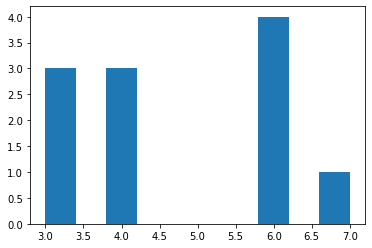

In [13]:
a = np.argmax(collaborators['col3'].data_loader.y_valid, axis =1)
import matplotlib.pyplot as plt
plt.hist(a)
collaborator_models[1].data_loader.y_valid.shape

We can see the current plan values by running the `fx.get_plan()` function

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [14]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,{'aggregator.settings.rounds_to_train':20})

In [15]:
#Save final model
final_fl_model.save_native('final_pytorch_model')